In [1]:
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from RL2 import ReplayBuffer, DQNAgent
from Environment import GridWorld
from utils import get_device
import os
import matplotlib.pyplot as plt


In [2]:
size = 5

In [3]:
file = f"ddqnout/{size}/"

In [4]:
try:
    os.mkdir(file)
except:
    pass

In [5]:
device = get_device()

In [6]:
lr = 2e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
epsilon = 1
target_update = 100
buffer_size = 100000000
minimal_size = 500
batch_size = 256
max_steps = 50
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

env = GridWorld((5,5),0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space
action_dim = env.action_space
agent = DQNAgent(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, "dqn")
done_counter = 0
return_list = []
steps_avg = []
episode = 0
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode += 1
            episode_return = 0
            state = env.reset()
            done = False
            steps = 0
            while not done:
                if steps > max_steps:
                    break
                steps += 1

                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action, steps)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                if done:
                    steps_avg.append(steps)
                    done_counter += 1
            if replay_buffer.size() > minimal_size:
                agent.update_epsilon(1/num_episodes)            
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:]),
                    'Theoretical Max Return':
                    '%.3f' % env.theoretical_max,
                    'epsilon':
                    '%.3f' % agent.epsilon,
                    'times completed':
                    '%d' % done_counter,
                    'avg steps':
                    '%.3f' % np.mean(steps_avg[-10:])
                })
            pbar.update(1)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\cg170794\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cg170794\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Iteration 9: 100%|██████████| 100/100 [00:29<00:00,  3.45it/s, episode=1000, return=-26.050, Theoretical Max Return=224.875, epsilon=0.009, times completed=0, avg steps=nan]


In [7]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

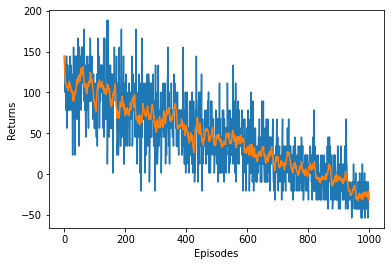

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.savefig(f'{file}returns.png')


mv_return = moving_average(return_list, 11)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.savefig(f'{file}returns_moving_average.png')

In [9]:
positiondict = {}
stepdict = {}
for i in range(4):
    for j in range(4):
        done = False
        state = env.reset_GivenPosition((i,j))
        states = []
        rewards = []
        rewards.append(0)
        states.append(state.copy())
        max_steps = 100
        steps = 0

        while not done:
            action = agent.take_action(state)
            state, reward, done, _ = env.step(action,steps)
            states.append(state.copy())
            rewards.append(rewards[-1] + reward)
            steps += 1

            if steps > max_steps:
                done = True


            positiondict[(i,j)] = (states,rewards)

        stepdict[(i,j)] = steps

In [10]:
temp = min(stepdict.values())
pos = [key for key in stepdict if stepdict[key] == temp][0]

In [11]:
states = []

In [12]:
actions = [2,2,1,3,3,3,0,0,0,2,2,2,1,3,3]

In [13]:
env = GridWorld((4,4),0)
env.reset()
step = 0

In [14]:
states.append(env.reset_GivenPosition((3,2)))

In [15]:
for action in actions:
    state, reward, done, _ = env.step(action,steps)
    states.append(state.copy())
    steps += 1


In [16]:
colors = {-1:(0,0,0), 0:(255,255,255), 1:(0,255,0), 2:(0,0,255), 3:(255,0,0)}
def draw_gridworld(state, grid_size):
    img = np.zeros((grid_size[0], grid_size[1], 3), dtype=np.uint8)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if state[i][j][1] == 1:
                img[i,j] = colors[1]
            else:
                img[i,j] = colors[state[i][j][1]]
    return img

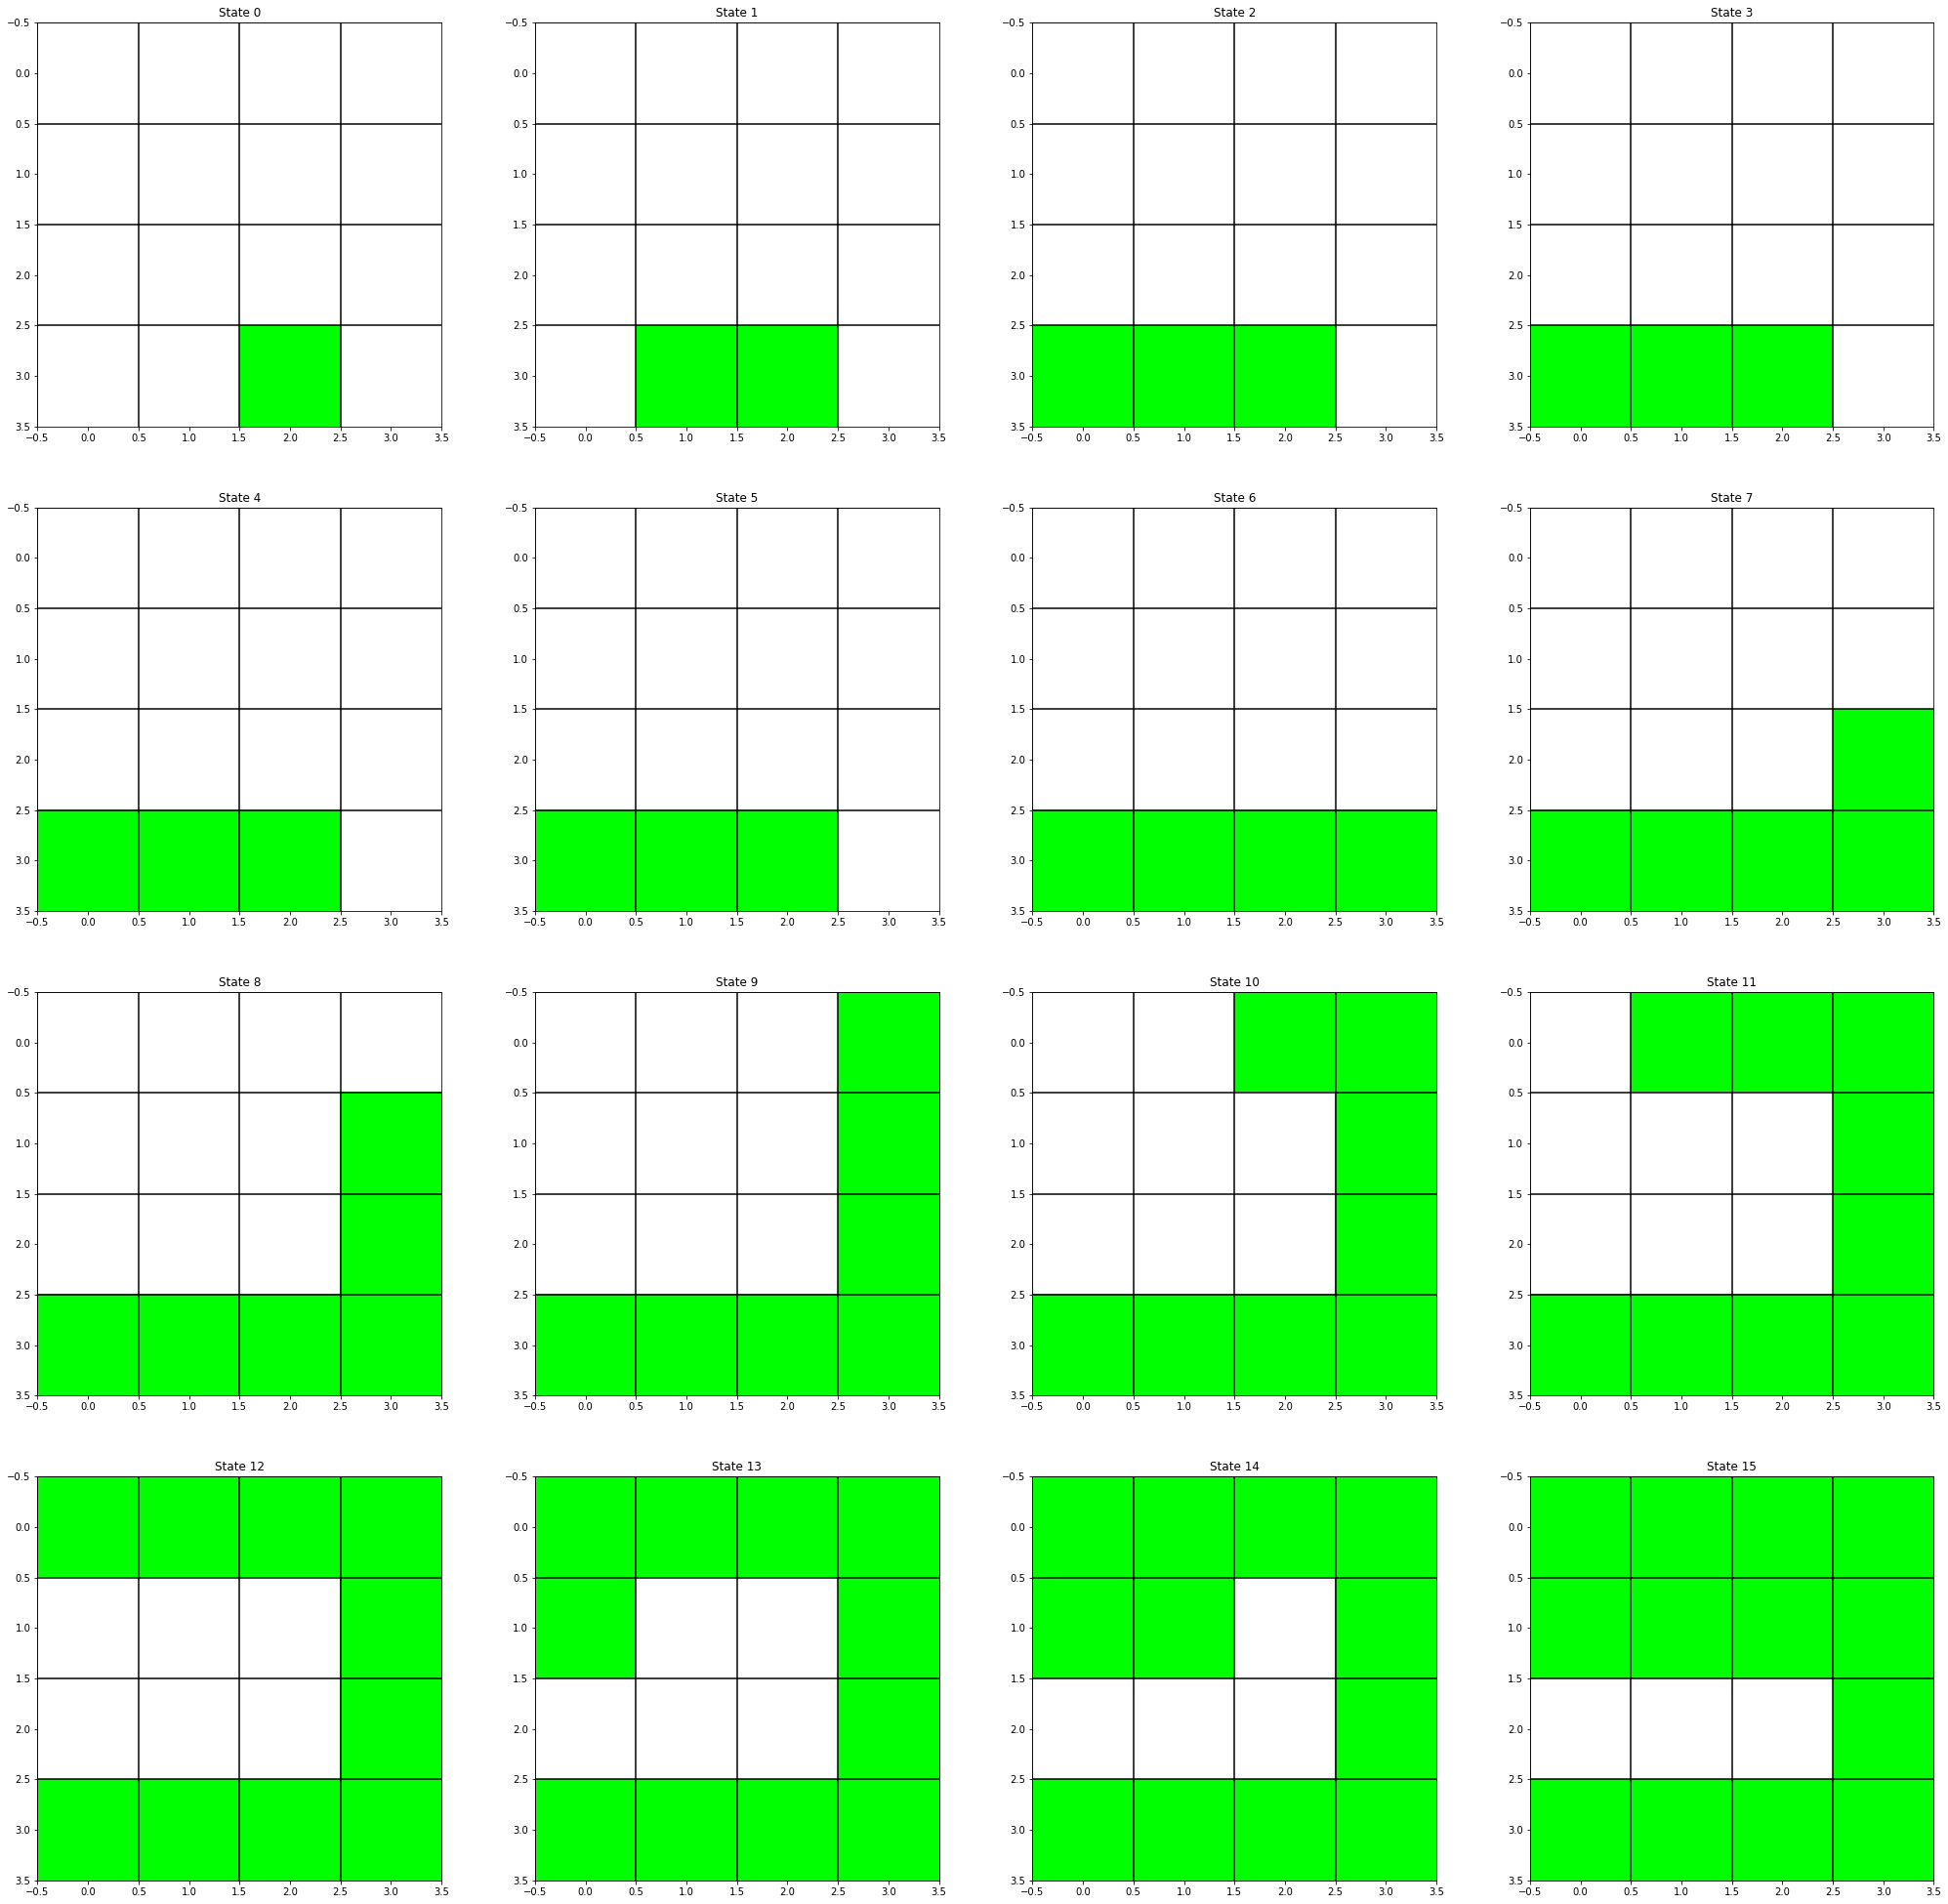

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(35, 35))
for i, state in enumerate(states):
    img = draw_gridworld(state, env.grid_size)
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title('State {}'.format(i))
    axs[i//4,i%4].axis('on')
    #draw grid
    for j in range(0, env.grid_size[0]):
        axs[i//4,i%4].axhline(y=j-0.5, color='k', linestyle='-')
        axs[i//4,i%4].axvline(x=j-0.5, color='k', linestyle='-')

plt.savefig(f'{file}DQN_states.png')

In [18]:
stepdict = {}
for i in range(5):
    for j in range(5):
        stepdict[(i,j)] = 0 

stepdict[(0,0)] = 24   

In [19]:
for i in stepdict:
    if stepdict[i] == size ** 2 - 1:
        pass
    else:
        stepdict[i] = np.random.randint(24,size ** 2 + 5)

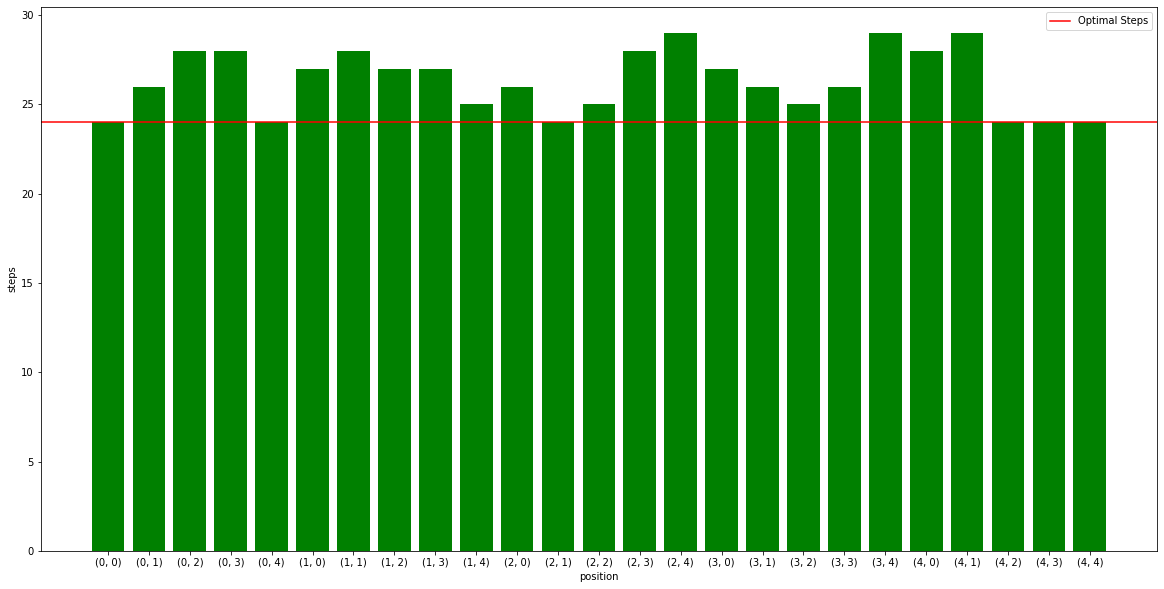

In [20]:
plt.figure(figsize=(20,10))
plt.bar([str(x) for x in list(stepdict.keys())],list(stepdict.values()),color='g')
plt.axhline(y=size**2-1, color='r', linestyle='-',label='Optimal Steps')
plt.xlabel('position')
plt.ylabel('steps')
plt.legend()
plt.savefig(f'{file}stepsbar.png')